In [4]:
import gpxpy
import gpxpy.gpx
gpx = gpxpy.parse(open('data/tokyo-men.gpx','r'))
new_points = []
points = gpx.tracks[0].segments[0].points
for i, point in enumerate(points):
    if i==0:
        new_points.append(point)
    else:
        if point.latitude != points[i-1].latitude and point.longitude != points[i-1].longitude:
            new_points.append(point)
gpx.tracks[0].segments[0].points = new_points
open('data/tokyo-men.gpx','w').write(gpx.to_xml())
gpx = gpxpy.parse(open('data/tokyo-men.gpx','r'))
alts = [point.elevation for point in gpx.tracks[0].segments[0].points]

<AxesSubplot:>

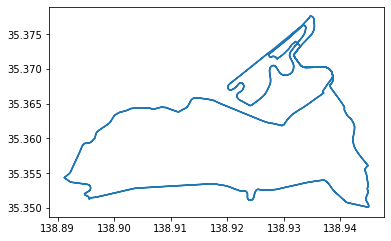

In [5]:
import geopandas as gpd
track = gpd.GeoDataFrame(columns=['name', 'geometry'], 
     geometry='geometry')
gdf = gpd.read_file('data/tokyo-men.gpx', layer='tracks')
gdf.plot()

In [6]:
gdf.head()

,name,cmt,desc,src,link1_href,link1_text,link1_type,link2_href,link2_text,link2_type,number,type,geometry
0,Tokyo 2020 Men Elite ITT,None,None,Generated by Anonymous using La Flamme Rouge t...,None,None,None,None,None,None,None,None,"MULTILINESTRING ((138.93119 35.37488, 138.9324..."


In [7]:
len(gdf.geometry[0].geoms[0].coords)

2282

In [8]:
#from shapely import geometry, ops
#singleline = ops.linemerge(gdf.geometry[0])
gdf.geometry[0]=gdf.geometry[0].geoms[0]

In [9]:
gdf.head()
print(gdf.geometry[0].coords[0])
gdf.crs

(138.93119, 35.37488)


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

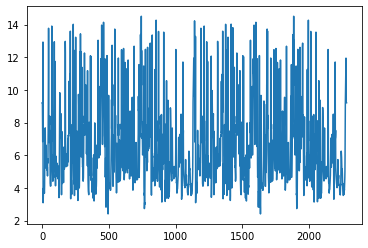

In [12]:
import pymap3d as pm
lat0 = gdf.geometry[0].coords[0][1]
lon0 = gdf.geometry[0].coords[0][0]
h0 = 0
lat = gdf.geometry[0].coords[1][1]
lon = gdf.geometry[0].coords[1][0]
h = 0
def get_local_coord(coord, coord0):
    lat0 = coord0[1]
    lon0 = coord0[0]
    lat = coord[1]
    lon = coord[0]
    return pm.geodetic2enu(lat, lon, 0, lat0, lon0, h0)[:2]
coords = gdf.geometry[0].coords
local_coords = [ get_local_coord(coord, coords[0]) for coord in coords]
local_coords

from scipy import optimize

x = [i[0] for i in local_coords[0:5]]
y = [i[1] for i in local_coords[0:5]]
x=[]
y=[]

def calc_R(xc, yc, x, y):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def f_2(c, x, y):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = np.sqrt((x-c[0])**2 + (y-c[1])**2)
    return Ri - Ri.mean()

def get_radius(i, local_coords, k):
    if i<k:
        return 10000
    if i+k>=len(local_coords):
        return 10000
    point_set = local_coords[i-k:i+k]
    x = [i[0] for i in point_set]
    y = [i[1] for i in point_set]
    
    center_estimate = (np.mean(x),np.mean(y))
    center, ier = optimize.leastsq(f_2, center_estimate, args=(x, y))
    #print(ier)
    Ri_2       = calc_R(*center, x, y)
    R_2        = Ri_2.mean()
    return R_2

get_radius(190, local_coords, 100)
radii = [get_radius(i, local_coords, 3) for i in range(len(local_coords))]
plt.plot(np.log(radii))

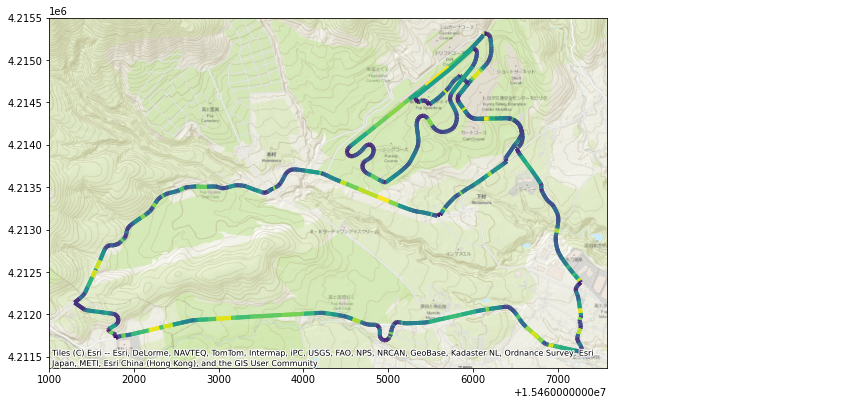

In [13]:
from shapely.geometry import Point
from shapely.geometry import LineString

import contextily as cx

def segments(curve):
    return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))

line_segments = segments(gdf.geometry[0])
segment_radius = [(radii[i]+radii[i+1])/2 for i in range(len(radii)-1)]

tokyo_lines = gpd.GeoDataFrame(columns=['radius','geometry'],geometry='geometry')
tokyo_lines.geometry = line_segments
tokyo_lines.radius = np.log(segment_radius)

tokyo_lines.crs='epsg:4326'
tokyo_lines = tokyo_lines.to_crs(epsg=3857)
ax = tokyo_lines.plot(tokyo_lines.radius,linewidth=4,figsize=(10,10))
cx.add_basemap(ax, source=cx.providers.Esri.WorldTopoMap)
#tokyo.explore(tokyo.radius)

# Point(coords[0])
# tokyo = gpd.GeoDataFrame(columns=['radius', 'geometry'], 
#          geometry='geometry')
# points = [Point(coords[i]) for i in range(len(coords))]
# tokyo.geometry = points
# tokyo.radius = np.log(radii)
# tokyo.explore(tokyo.radius)

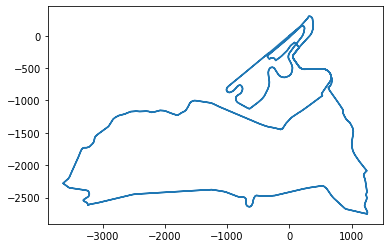

In [14]:
x = [i[0] for i in local_coords]
y = [i[1] for i in local_coords]
plt.plot(x,y)

In [15]:
# import sys
# sys.path.append('../elevation_profile')
# from ElevationSampler import DEM
# import pandas as pd
# from shapely.geometry import  LineString

# elevation_model = DEM("data/ASTGTMV003_N35E138_dem.tif")

# # define a line to sample along / or wrap in a geopandas GeoSeries for crs handling
# line = gdf.geometry[0]

# # sample every 10m along the line
# sample_distance = 10
# elevation_profile = elevation_model.elevation_profile(line, distance=sample_distance, interpolated=True)
# print(elevation_profile.inclination(degrees=True))

In [16]:
import srtm1
import matplotlib.pyplot as plt
# def coord_to_alt(coord):
#     lat = coord[1]
#     lon = coord[0]
#     return srtm1.read('data/ASTGTMV003_N35E138_dem.tif',lat, lon)



coord1 = gdf.geometry[0].coords[0]
print(coord1)
lat = coord1[1]
lon = coord1[0]
#alts = [coord_to_alt(coord) for coord in gdf.geometry[0].coords]
alt_diffs = [alts[i+1]-alts[i] for i in range(len(alts)-1)]
#dists = 
plt.plot(alts)
plt.plot(alt_diffs)
sum([abs(diff) for diff in alt_diffs])


ModuleNotFoundError: No module named 'srtm1'

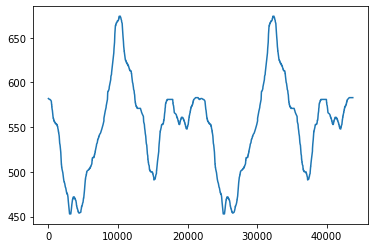

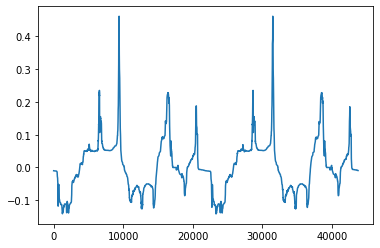

In [73]:
from haversine import haversine_vector, Unit
import numpy as np
coords_latlon = [x[::-1] for x in gdf.geometry[0].coords]
dists = haversine_vector(coords_latlon[1:],coords_latlon[:-1], Unit.METERS)
#slopes = alt_diffs/dists #too noisy!
sum(dists)
cum_dists = np.insert(np.cumsum(dists),0,0)
smoothing = 50
alt_diffs_smooth = [alts[(i+smoothing)%len(alts)]-alts[i-smoothing] for i in range(len(alts))]
dists_smooth = haversine_vector(np.roll(coords_latlon,-smoothing),np.roll(coords_latlon,smoothing), Unit.METERS)
slopes = alt_diffs_smooth/dists_smooth
#cum_dists_smooth = np.cumsum(dists_smooth)
#todo: calculate slopes CENTERED around points

plt.plot(cum_dists,alts)
plt.show()
plt.plot(cum_dists,slopes)

In [232]:
points = []
mu_s = 0.5
for i in range(len(alts)):
    theta = 0
    r = radii[i]
    vmax = math.sqrt(r * g * (sin(theta)+mu_s * cos(theta))/(cos(theta)-mu_s * sin(theta)))
    point = {'lon': gdf.geometry[0].coords[0], 'lat': gdf.geometry[0].coords[1],
             'alt': alts[i], 'slope': slopes[i], 'radius': radii[i], 'cumdist':cum_dists[i],
             'vmax':vmax}
    points.append(point)

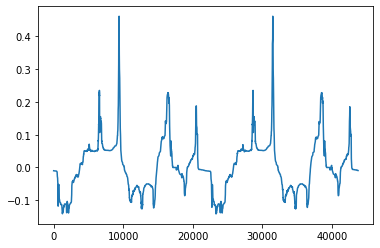

In [75]:
plt.plot([p['cumdist'] for p in points], [p['slope'] for p in points])

In [76]:
np.argmin(dists)

14

In [292]:
def interp(d1, d2, weight):
    return d1 * weight + d2 * (1-weight)
import math

def data(x):
    #i=np.argmax([p['cumdist']>0 for p in points])
    i=0
    while(points[i]['cumdist']<x):
        i+=1
    p1 = points[i-1]
    p2 = points[i]
    weight = (p2['cumdist']-x)/(p2['cumdist']-p1['cumdist'])
    slope = np.arctan(interp(p1['slope'],p2['slope'],weight))
    r = interp(p1['radius'],p2['radius'],weight)
    vmax = interp(p1['vmax'],p2['vmax'],weight)
    alt = interp(p1['alt'],p2['alt'],weight)

    
    return slope, r, vmax, alt
    
    

In [153]:
data(300)

(-0.010669226484030816, 0.0002056663691096341)

# DIFF EQ

In [173]:
def P(x):
    return 450
def T(P):
    return 1/P * 1000

In [236]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

from math import sin, cos
v0 = 0.001
e0 = 1
x_max = max(cum_dists)
m = 70
x0 = 0

Cd = 0.05
rho = 1.29 # should be function of air density
A = 0.4
g = 9.81
mu = 0.002


S0 = [x0, v0, e0]

def f(S, t):
    x, v, e = S
    
    slope, r, vmax, alt = data(x)
    
    if(v>vmax):
        print(v)

    
    a = (P(x)/v - Cd*rho*A*(v**2)/2 - m*g*(sin(slope)+mu*cos(slope)))/m
    #a = (P(x)/v)/m
    #print(a,v)
    dxdt = v
    dvdt = a
    
    dedt = -1/T(P(x))
    
    return [dxdt, dvdt, dedt]

t_span = np.linspace(0, 500, 1000)
solution = odeint(f, S0, t_span)



20.995639691292673
20.995576443565312
20.93724691203355
20.93724151193705
20.937247282668295
20.937245317964813
20.9621395063825
20.962138713286986
20.986994019611416
20.986996779627177
21.011820180778674
21.01182018011765
21.16593023871524
21.165930970127192
21.318727873061412
21.319085008446912
21.22528214590699
21.225296538941784
21.1778169795425
21.177817542004142
21.189697352669235
21.189697358849024
21.201570424327624
21.201570430492797
21.22529637241127
21.22529638258798
21.24899551281225
21.24899550231995
21.272667885476956
21.2726678852705
21.296313628714362
21.296320715360864
21.296313612489932
21.296322140826412
21.277399161874442
21.277399162064796
21.282129373659544
21.282129374046622
21.286858521603044
21.286858521989732
21.296313627950642
21.296316463333937
21.305780359320572
21.305780779104253
21.315259371674195
21.31525611504776
21.324741824927315
21.324741825106937
21.401560124170945
21.401560128517634
21.479053829071535
21.478863866198633
21.449613651735987
21.449527

59.175053929144234
59.17510450357921
59.175053764322065
59.175114701109955
59.18945836971742
59.1894583736763
59.18467316807118
59.18467317203064
59.175053923484214
59.175074159739374
59.17505391292447
59.17507821227624
59.18275453149673
59.18275453194026
59.180833287093094
59.180833287346566
59.178909438503474
59.17891067840303
59.17506533555318
59.175069382233744
59.176776978476695
59.17677822441657
59.17464577001385
59.17464701568284
59.170387088775584
59.17038708822238
59.166132141554094
59.16613214047108
59.16188217108728
59.16187468782145
59.16295887567346
59.16295589340173
59.159776458012594
59.15977177009633
59.15657508398259
59.15657508597998
59.15014403739867
59.150144049386775
59.143662798036
59.14366281403265
59.13713139592698
59.13713141193888
59.069064440911276
59.069630540043
59.101364840088145
59.10136629351754
59.064170880955544
59.06463256221979
59.09444799328021
59.09444804539954
59.08747883603793
59.08748180413091
59.08047053785489
59.08049275173764
59.0838468848896

17.96928849871402
17.969289847378114
17.867985843192645
17.86874471830891
17.940370567567122
17.940370886263683
17.911200151619056
17.911285537874456
17.933809628120148
17.93380965141638
17.927235639951704
17.927239654534922
17.92970260504935
17.929703655240594
17.92559476820585
17.92559614885932
17.921488512423917
17.921488512917467
17.91327285550322
17.91327285846484
17.905056695111128
17.905056699060715
17.89684003865174
17.89684004260175
17.814647673305647
17.81464783928817
17.73241481641064
17.731693499836936
17.767826222304393
17.767627694270427
17.80668777632156
17.806687777198764
17.79872733481784
17.798727338407
17.79076652591401
17.790765151431277
17.78279984406887
17.782789965476532
17.787087455477398
17.787085348539964
17.790029665942722
17.79002958164949
17.78929381610162
17.78929381611591
17.78855785540418
17.788557855418503
17.78708534862306
17.787085348646947
17.78561206160549
17.785612061581638
17.784137994447107
17.782663147472782
17.767871837032178
17.76787183704301


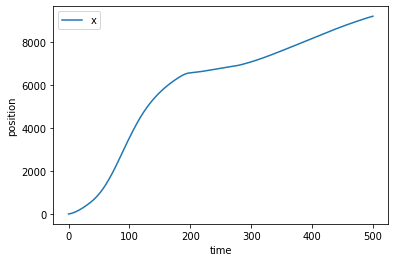

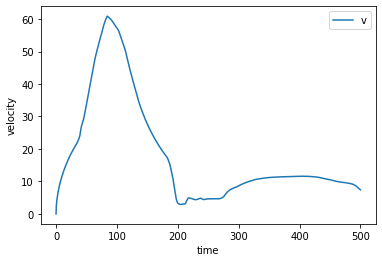

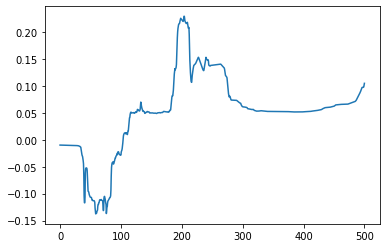

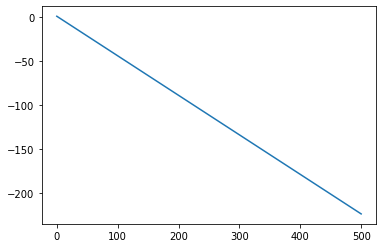

In [245]:
x = solution[:, 0]
v = solution[:, 1]
e = solution[:, 2]

slope = [data(x_pos)[0] for x_pos in x]

plt.plot(t_span, x, label='x')
#plt.plot(t_span, solution[:, 1], label='v')
plt.legend()
plt.xlabel('time')
plt.ylabel('position')
plt.show()
plt.plot(t_span, v, label='v')
#plt.plot(t_span, solution[:, 1], label='v')
plt.legend()
plt.xlabel('time')
plt.ylabel('velocity')
plt.show()
plt.plot(t_span, slope)
plt.show()

plt.plot(t_span, e)

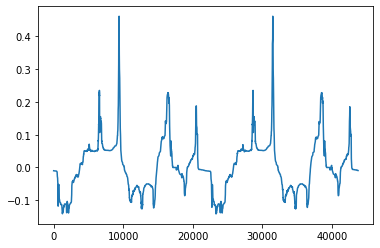

In [178]:
plt.plot([p['cumdist'] for p in points], [p['slope'] for p in points])

# Track Discretization

In [296]:
from scipy.signal import find_peaks
#plt.plot(alts)
peaks = find_peaks(np.array(alts),height=10)[0]
troughs = find_peaks(-np.array(alts)+max(alts),height=10)[0]



In [299]:
vmax = [p['vmax'] for p in points]
# convert vmax values to be based on x
max_dist = math.ceil(max(cum_dists))
vmax = np.zeros(max_dist)
print('hmm')
for i in range(max_dist):
    vmax[i] = data(i)[2]
print('hmm')
vmax_seps = find_peaks(-np.array(vmax)+max(vmax),height=10,distance=200)
heights = -vmax_seps[1]['peak_heights']+max(vmax)
cutoff = heights < 20

curveseps = vmax_seps[0]
curveseps = curveseps[cutoff]
brakeseps = np.array(curveseps)-100

print('hmm')

#plt.plot(cum_dists,vmax)


hmm
hmm
hmm


(0.0, 50.0)

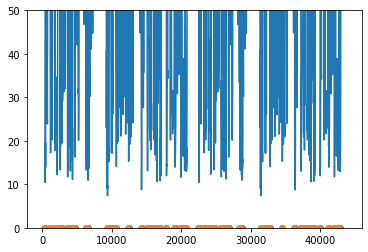

In [300]:

plt.scatter(curveseps,np.zeros(len(seps)))
plt.scatter(brakeseps,np.zeros(len(seps)))
plt.plot(vmax)
plt.ylim(0,50)

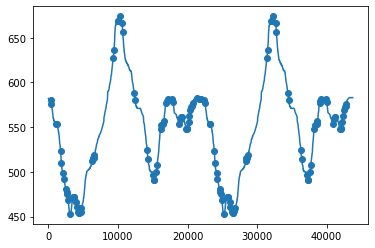

In [304]:
seps = np.append(peaks,troughs)
sep_x = [cum_dists[sep] for sep in seps]
sep_x = np.append(sep_x,[curveseps, brakeseps])
sep_alt = [data(x)[3] for x in sep_x]

#plt.scatter(curveseps,np.zeros(len(seps)))
#plt.scatter(brakeseps,np.zeros(len(seps)))
plt.scatter(sep_x, sep_alt)
plt.plot([p['cumdist'] for p in points], [p['alt'] for p in points])

# Power Curve Calculation

In [179]:
x = [5, 1*60, 5*60, 60*60]
y = [24.04, 11.5, 7.6, 6.4]

(0.0, 30.0)

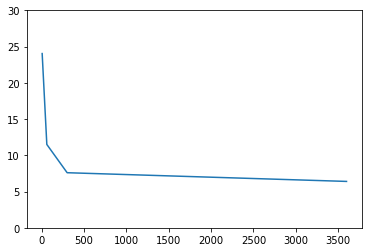

In [183]:
plt.plot(x,y)
plt.ylim(0,30)